# LIGO Detectability (Classification)

### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import corner

In [2]:
f = h5py.File('../solutions/sample_2e7_design_precessing_higherordermodes_3detectors.h5')

In [3]:
keys = list(f.keys())
print('keys : ', keys)
print(f['mtot'].shape)

keys :  ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
(20000000,)


## Prepare Data

In [4]:
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve

In [5]:
#Downsample
N_sample = 100000

#Labels
y = np.array(f['det'][:N_sample])
y_snr = np.array(f['snr'][:N_sample])

#Data
keys.remove('det')
keys.remove('snr')

X=[]
for k in keys:
    X.append(f[k][:N_sample])
X=np.array(X).T

print(X.shape)
print(y.shape)

(100000, 13)
(100000,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)
print(X_train.shape)

(67000, 13)


## Decision Tree Classifier (All Parameters)

### Depth (GridSearchCV)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_cl = DecisionTreeClassifier()
drange = np.arange(1,21)  
criteria = ['gini', 'entropy', 'log_loss']

grid = GridSearchCV(dt_cl, param_grid={'max_depth': drange, 'criterion': criteria}, cv=5) 
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best_criterion = grid.best_params_['criterion']
print("best parameter choice:", best_criterion)

best parameter choice: 8
best parameter choice: gini


### Bagging (BaggingClassifier)

In [8]:
from sklearn.ensemble import BaggingClassifier
bg_cl = BaggingClassifier(
    DecisionTreeClassifier(random_state=42, max_depth=best, criterion=best_criterion), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=2)

bg_cl.fit(X_train, y_train)

y_pred = bg_cl.predict(X_test)
y_prob = bg_cl.predict_proba(X_test)[:,1]



In [9]:
print(y_prob.shape)

(33000,)


### ROC and Contamination/Completeness

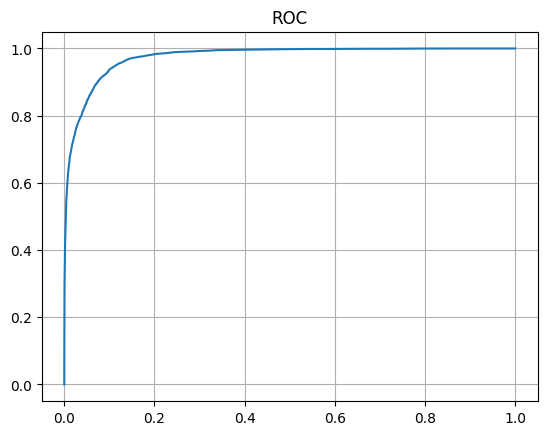

In [10]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.title('ROC')
plt.grid()
plt.show()

In [11]:
completeness, contamination = completeness_contamination(y_pred, y_test)
print('Completeness: ', completeness)
print('Contamination: ', contamination)

Completeness:  0.7883180558516307
Contamination:  0.20473118279569893


In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.941060606060606


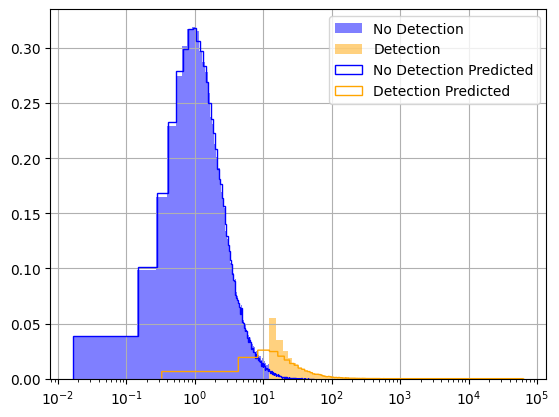

In [15]:
y_pred = bg_cl.predict(X)
plt.hist(y_snr[y==0],bins='fd', density=True, color='blue', label = 'No Detection', alpha=0.5)
plt.hist(y_snr[y==1], bins='fd', density=True, color='orange', label= 'Detection', alpha=0.5)

plt.hist(y_snr[y_pred==0],bins='fd', density=True, histtype='step', color='blue', label = 'No Detection Predicted')
plt.hist(y_snr[y_pred==1], bins='fd', density=True,histtype='step', color='orange', label= 'Detection Predicted')

plt.xscale('log')
plt.grid()
plt.legend()



The classifier does not predict correctly the signals having snr lower than 12.

## Decision Tree Classifier (Different n Parameters)

### Dimensionality Reduction

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFreg = RandomForestRegressor() # Complete or leave blank as you see fit
RFreg.fit(X[:1000],y[:1000]) # Do Fitting
importances = RFreg.feature_importances_# Determine pixel "importances"
index_importances = np.argsort(importances)[::-1] # Rank importances (highest to lowest)
print(index_importances) 
parameters_GW_byimportance = [keys[p] for p in index_importances]
print(parameters_GW_byimportance)



[12  8  2  7  6  4 10 11  9  5  3  1  0]
['z', 'mtot', 'chi1z', 'iota', 'dec', 'chi2y', 'q', 'ra', 'psi', 'chi2z', 'chi2x', 'chi1y', 'chi1x']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)
print(X_train.shape)

(67000, 13)


In [ ]:
def get_results_BaggingCl(X_train, y_train, X_test, y_test):
    bg_cl = BaggingClassifier(
        DecisionTreeClassifier(random_state=42, max_depth=best, criterion=best_criterion), 
        n_estimators=500, max_samples=100, 
        bootstrap=True, random_state=42, n_jobs=2)

    bg_cl.fit(X_train, y_train)

    y_pred = bg_cl.predict(X_test)
    y_prob = bg_cl.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    completeness, contamination = completeness_contamination(y_pred, y_test)
    accuracy = accuracy_score(y_test, y_pred)

    return fpr, tpr, completeness, contamination, accuracy


In [ ]:
n_parameters = []
false_positives = [] 
true_positives = []
completeness_total = [] 
contamination_total = []
accuracy_total = []

for n_indexes in range(len(index_importances)):
    indexes = index_importances[:n_indexes+1]  
    X_train_ind = X_train[:, index_importances[0]]
    X_test_ind = X_test[:, index_importances[0]]
    
    if n_indexes > 0:
        for ind in indexes[1:]:
            X_train_ind = np.vstack((X_train_ind ,X_train[:, index_importances[ind]]))
            X_test_ind = np.vstack((X_test_ind,X_test[:, index_importances[ind]]))
    
        X_train_ind = X_train_ind.T
        X_test_ind = X_test_ind.T
        #print(X_train_ind.shape)

        n_parameters.append(n_indexes + 1)
        fpr, tpr, completeness, contamination, accuracy = get_results_BaggingCl(X_train_ind, y_train, X_test_ind, y_test)
        false_positives.append(fpr)
        true_positives.append(tpr)
        completeness_total.append(completeness)
        contamination_total.append(contamination)
        accuracy_total.append(accuracy)
    else : 
        X_train_ind = X_train_ind.reshape(-1, 1)
        X_test_ind = X_test_ind.reshape(-1,1)

        n_parameters.append(n_indexes + 1)
        fpr, tpr, completeness, contamination, accuracy = get_results_BaggingCl(X_train_ind, y_train, X_test_ind, y_test)
        false_positives.append(fpr)
        true_positives.append(tpr)
        completeness_total.append(completeness)
        contamination_total.append(contamination)
        accuracy_total.append(accuracy)

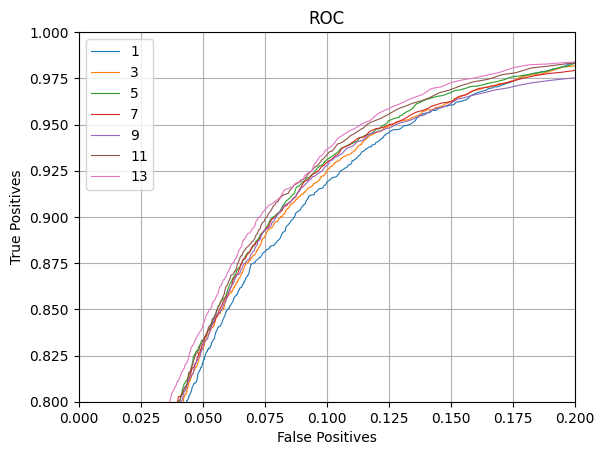

In [ ]:
lst = np.arange(len(n_parameters))
for i in lst[::2]:
    plt.plot(false_positives[i], true_positives[i], label = n_parameters[i], linewidth = 0.8)
plt.title('ROC')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.legend()
plt.grid()
plt.xlim(0.,0.2)
plt.ylim(0.8, 1.)
plt.show()

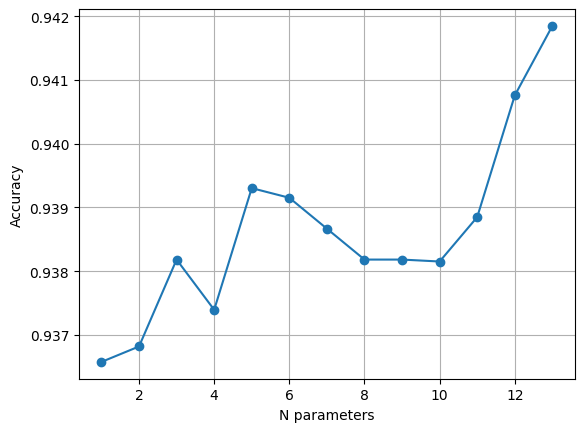

In [ ]:
plt.plot(n_parameters, accuracy_total, marker='o')
plt.xlabel('N parameters')
plt.ylabel('Accuracy')
plt.grid()